# 实验二 车标的定位和识别

## 1. 实验任务

- 假设车牌位置已知，基于车牌位置，如何进行车标的粗略定位？
- 提取车标区域的特征，进行特征匹配，以识别出该车辆属于哪个品牌。

## 2. 实验内容

### 2.1 数据预处理及探索性数据分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import os
import gc
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
from tensorboardX import SummaryWriter
import torch.utils.data as data
# %matplotlib inline

In [2]:
data_path = './VehicleLogo_Dataset/'
X = []
y = []
for img_path in os.listdir(data_path):
#     gray = cv2.cvtColor(cv2.imread(data_path + img_path), cv2.COLOR_RGB2GRAY).ravel()
    gray = cv2.cvtColor(cv2.imread(data_path + img_path), cv2.COLOR_RGB2GRAY)
    X.append(gray)
    y.append(int(img_path.split('_')[0]))
# X = np.asarray(X)
# y = np.asarray(y)

In [4]:
len(y)

11500

每张图片的大小为70 $\times$ 70，也就是说每张图片有4900个特征

为了训练，要确保数据集是平衡的。接下来就检查每个类别有多少数据

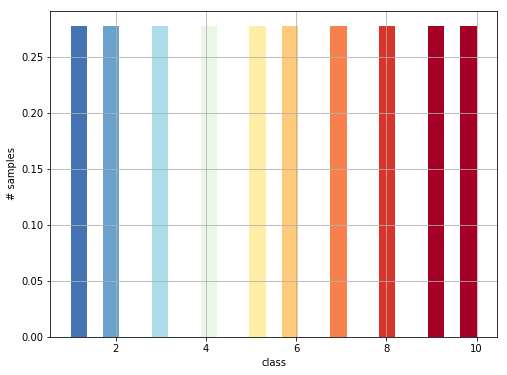

Counter({10: 1150, 1: 1150, 2: 1150, 3: 1150, 4: 1150, 5: 1150, 6: 1150, 7: 1150, 8: 1150, 9: 1150})


In [5]:
plt.figure(figsize=(8, 6))
plt.xlabel('class')
plt.ylabel('# samples')
plt.grid('on')
cm = plt.cm.get_cmap('RdYlBu_r')
counter = collections.Counter(y)
stat_x, stat_y = [], []
for key, val in dict(counter).items():
    stat_x.append(key)
    stat_y.append(val)

n, bins, patches = plt.hist(stat_x, 25, normed=1, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col+.1, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.savefig('EDA.png')
plt.show()
print(counter)

数据集是平衡的，我们可以直接将数据集分割后开始设计算法

In [3]:
from sklearn.model_selection import train_test_split
seed = 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [4]:
X_train = np.asarray([np.expand_dims(x, axis=0) for x in X_train])
X_test = np.asarray([np.expand_dims(x, axis=0) for x in X_test])
## 适应后面的pytorch训练过程中的Cross Entropy Loss
y_train = np.array(y_train).reshape(-1, 1) - 1
y_test = np.array(y_test).reshape(-1, 1) - 1

In [145]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

8050 3450 8050 3450


### 2.2 使用RandomForest进行分类

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf = RandomForestClassifier(n_estimators=300, max_depth=10, max_features=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

             precision    recall  f1-score   support

          1     0.9757    0.9469    0.9611       339
          2     0.9670    0.8567    0.9085       342
          3     0.9942    0.9744    0.9842       351
          4     0.9944    0.9416    0.9673       377
          5     0.9969    0.9444    0.9700       342
          6     0.8304    0.9542    0.8880       349
          7     0.9968    0.9813    0.9890       321
          8     0.9554    0.9885    0.9717       347
          9     0.9156    0.9830    0.9481       353
         10     0.9467    0.9726    0.9595       329

avg / total     0.9572    0.9542    0.9546      3450



### 2.3 Convolutional Neural Network

#### 2.3.1 训练

In [5]:
## 构造数据集
class MyDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return torch.FloatTensor(self.X[index]), torch.LongTensor(self.y[index])

dataset = MyDataset(X_train, y_train)
print(len(dataset))
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

8050


In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(9248, num_classes)
#         self.fc2 = nn.Linear(500, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
#         out = self.fc2(out)
        return out
    
def train(model, dataloader, lr, criterion, optimizer, max_iter):
    Loss = []
    
    loss = None
    writer = SummaryWriter('log_5_29')
    for epoch in range(max_iter):
        print('Training epoch {}'.format(epoch))
        for i, iter_data in enumerate(data_loader):
            X_train, y_train = iter_data
#             print(X_train.size(), y_train.size())
            optimizer.zero_grad()
            output = model(Variable(X_train))
            loss = criterion(output, Variable(y_train.squeeze()))
            loss.backward()
            optimizer.step()
            Loss.append(loss.data[0])
            if i % 20 == 0:
                print('\r\t Training batch {}\t loss: {:>10}'.format(i, loss.data[0]), end='')
                writer.add_scalar('Train/loss', loss.data[0], i*(epoch+1))
        writer.add_scalar('Train/loss_epoch', loss.data[0], epoch)
        writer.add_histogram('Train/fc1_weights', model.fc1.weight.data, i*(epoch+1))
#         writer.add_histogram('Train/fc2_weights', model.fc2.weight.data, i*(epoch+1))
        print()
    writer.close()
    return Loss, model

In [8]:
lr = 1e-3
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
Loss, cnn = train(cnn, data_loader, lr, criterion, optimizer, 5)
torch.save(cnn, 'CNN_checkpoint/cnn_5_25.pkl')

Training epoch 0
	 Training batch 1000	 loss: 0.097040705382823945
Training epoch 1
	 Training batch 1000	 loss: 0.3016302883625030586
Training epoch 2
	 Training batch 1000	 loss: 0.2684373855590820324
Training epoch 3
	 Training batch 1000	 loss: 0.00022919637558516115
Training epoch 4
	 Training batch 1000	 loss: 0.0002514057850930847


D:\Anaconda3_501\lib\site-packages\torch\serialization.py:158: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [16]:
# loss = [l.data[0] for l in Loss]
plt.figure(figsize=(10, 8))
plt.title('Training loss')
plt.axis('on')
plt.xlabel('#iteration')
plt.ylabel('Loss')
plt.plot(Loss)
plt.savefig('Loss.png')

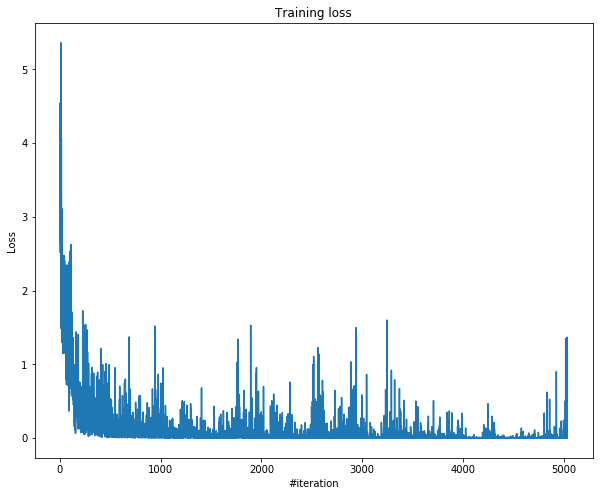

In [17]:
plt.show()

#### 2.3.2 测试

In [9]:
cnn.eval()
test_loader = data.DataLoader(MyDataset(X_test, y_test), batch_size=8, shuffle=False)
# eval_loss = 0.
# eval_acc = 0.
# correct = 0
# total = 0
y_preds = []
for batch_X, batch_y in test_loader:
    batch_X, batch_y = Variable(batch_X, volatile=True), Variable(batch_y.squeeze(), volatile=True)
    output = cnn(batch_X)
    _, pred = torch.max(output, 1)
#     total += batch_y.size(0)
#     correct += (pred == batch_y).sum()
    y_preds += pred.data.numpy().tolist()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_preds, y_test, digits=4))
# print(100 * correct / total)

             precision    recall  f1-score   support

          0     0.9882    0.9853    0.9867       340
          1     0.9971    0.9688    0.9827       352
          2     0.9972    1.0000    0.9986       350
          3     0.9735    1.0000    0.9866       367
          4     0.9825    0.9600    0.9711       350
          5     0.9857    1.0000    0.9928       344
          6     0.9938    0.9907    0.9922       322
          7     1.0000    0.9914    0.9957       350
          8     0.9688    0.9828    0.9757       348
          9     0.9848    0.9908    0.9878       327

avg / total     0.9871    0.9870    0.9869      3450



#### 2.3.3 可视化

可视化神经网络的卷积核

In [16]:
list(cnn.layer1[0].parameters())[0][0]

Variable containing:
(0 ,.,.) = 
  0.0230  0.3064  0.3893
 -0.2546 -0.2724  0.1008
 -0.1751  0.0396 -0.0990
[torch.FloatTensor of size 1x3x3]